In [1]:
import os
from glob import glob
import threading

import numpy as np
import dask.dataframe as dd
from dask import delayed
import pandas as pd
import xarray as xr

%matplotlib inline
from matplotlib import pyplot as plt
#import matplotlib.animation as anima

import crocosi.postp as pp
from crocosi.jet import set_relevant_time

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/distributed/utils.py:133: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  RuntimeWarning,


In [86]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
w = cluster.scale(28*2)

In [87]:
from dask.distributed import Client
#client = Client()  # set up local cluster on your laptop
client = Client(cluster) # with distributed cluster

In [6]:
client

Client Scheduler: tcp://10.148.1.93:45050 Dashboard: http://10.148.1.93:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [2]:
root_path = '/home/datawork-lops-osi/slgentil/croco/jetn/'
#root_path = '/home1/datawork/slgentil/'#jet_cfg1_wp75_4km_1500a2000j_floats_lev50
run = 'jet_cfg1_wp75_4km_1500a2000j_floats_lev50_itide/'

In [83]:
run.find('km')

15

In [84]:
run[run.find('km')-1]

'4'

In [3]:
df = dd.read_csv(glob(root_path+run+'t1/float.????'), 
                 names=['id','time','xgrid','ygrid','zgrid','depth','temp','u','v','dudt','dvdt','pres'],
                 delim_whitespace=True).persist()
df.head()

,id,time,xgrid,ygrid,zgrid,depth,temp,u,v,dudt,dvdt,pres
0,7161,1500.0069,196.40944,541.79652,50.0,-0.935944,25.886666,0.058079,-0.105506,-5.820925e-08,3.420817e-07,-8.260263
1,7162,1500.0069,196.40937,543.30184,50.0,-0.940022,25.885229,0.057283,-0.101750,-2.034746e-08,3.515808e-07,-8.300321
2,7163,1500.0069,196.40946,544.80716,50.0,-0.944117,25.884374,0.058512,-0.097537,-1.201106e-09,3.599363e-07,-8.340519
3,7164,1500.0069,196.40961,546.31250,50.0,-0.948345,25.884627,0.060480,-0.093268,-1.958836e-08,3.627984e-07,-8.381996
4,7165,1500.0069,196.40971,547.81780,50.0,-0.952706,25.885603,0.061626,-0.089432,-6.096121e-08,3.575484e-07,-8.424740


In [4]:
df_pd = df.compute()

### Mean currents with floats

In [5]:
y_bins = np.arange(0., 600., 10.)
y_idx = pd.IntervalIndex.from_breaks(y_bins)
df_pd['y'] = pd.cut(df_pd.ygrid, bins=y_bins)

In [6]:
x_bins = np.arange(1., 260., 10.)
x_idy = pd.IntervalIndex.from_breaks(x_bins)
df_pd['x'] = pd.cut(df_pd.xgrid, bins=x_bins)

In [34]:
dfi = df_pd[df_pd.time==df_pd.time.min()]

In [35]:
test1 = dfi.groupby(['x','y'])['u'].mean()

In [9]:
test1.values[np.isnan(test1.values)==False].shape

(897,)

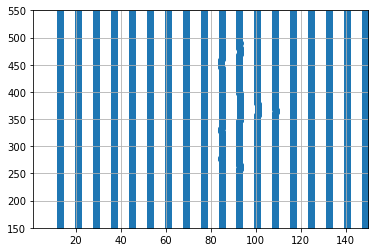

In [10]:
fig,ax=plt.subplots()
ax.scatter(dfi.xgrid,dfi.ygrid)
ax.grid()
ax.set_ylim(150,550);ax.set_xlim(1,150);

In [11]:
print(test1.values.shape,x_bins.size*y_bins.size)

(936,) 1000


In [40]:
Test1 = test1.values.reshape(x_bins.size-1,y_bins.size-1)

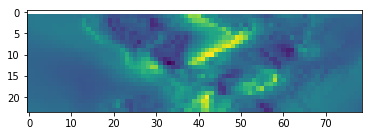

In [41]:
plt.imshow(Test1)

In [7]:
df_pd['U'] = np.sqrt(df_pd['u']**2+df_pd['v']**2)

In [55]:
print(df_pd.u.size,df_pd.U.size)

127168457 127168457


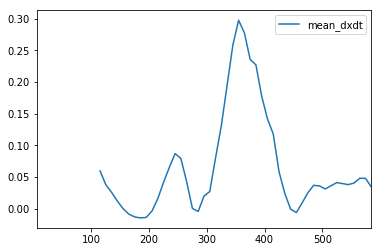

In [36]:
df_pd.groupby('y')['u'].mean().to_frame(name='mean_dxdt').set_index(y_idx.mid).plot()

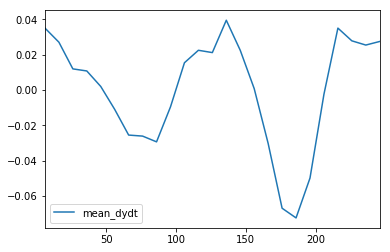

In [37]:
df_pd.groupby('x')['v'].mean().to_frame(name='mean_dydt').set_index(x_idy.mid).plot()

In [8]:
u_mean = df_pd.groupby(['x','y'])['u'].mean()

In [9]:
v_mean = df_pd.groupby(['x','y'])['v'].mean()

In [10]:
U_mean = df_pd.groupby(['x','y'])['U'].mean()

In [11]:
#test.plot()
print(test.size,x_bins.size*y_bins.size)

NameError: name 'test' is not defined

In [12]:
Umean = U_mean.values.reshape(x_bins.size-1,y_bins.size-1)
umean = u_mean.values.reshape(x_bins.size-1,y_bins.size-1)
vmean = v_mean.values.reshape(x_bins.size-1,y_bins.size-1)

In [13]:
X,Y = np.meshgrid(x_bins[:-1],y_bins[:-1])

In [110]:
X.shape

(59, 25)

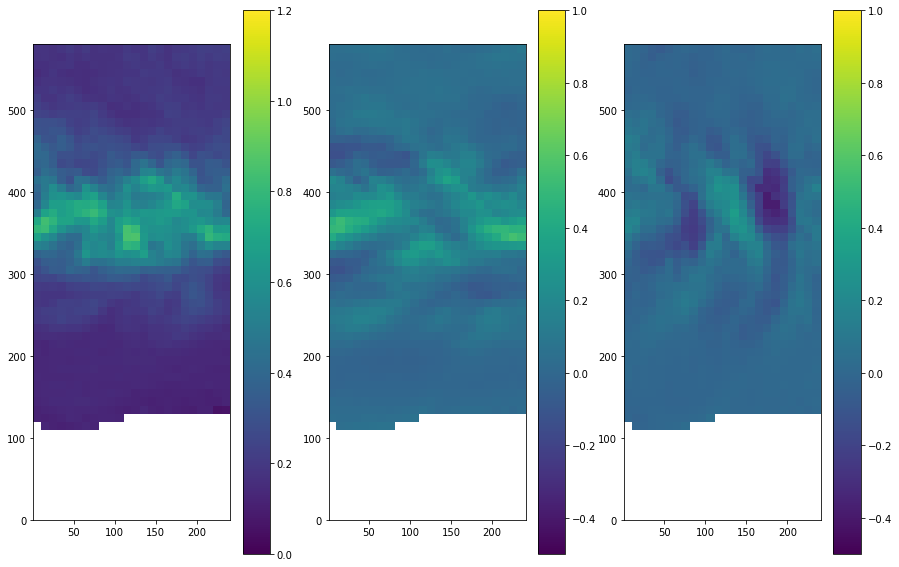

In [21]:
fig =plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,3,1)
cs = ax.pcolor(X,Y,Umean.T,vmax=1.2,vmin=0)
ax.set_aspect('equal')
plt.colorbar(cs)
ax1 = fig.add_subplot(1,3,2)
cs1 = ax1.pcolor(X,Y,umean.T,vmax=1.,vmin=-0.5)
ax1.set_aspect('equal')
plt.colorbar(cs1)
ax2 = fig.add_subplot(1,3,3)
cs2 = ax2.pcolor(X,Y,vmean.T,vmax=1.,vmin=-0.5)
ax2.set_aspect('equal')
plt.colorbar(cs2)

In [22]:
def s2day(s):
    return np.around(s/(24*3600),decimals=4)

In [23]:
idini = df_pd.groupby('time').get_group(1500.0069).sort_values('id').id

In [24]:
idmid = df_pd.groupby('time').get_group(1500+s2day(600*6*24*50)).sort_values('id').id

In [25]:
idfin = df_pd.groupby('time').get_group(1600).sort_values('id').id

In [26]:
lost = idini[np.isin(idini,idfin)==False]

In [155]:
idini[np.isin(idini,idmid)==False]

0         1
16       77
8       269
55      456
93      674
       ... 
226    8607
275    8836
241    8842
243    8844
240    8881
Name: id, Length: 162, dtype: int64

In [163]:
np.array(lost)

array([   1,   77,  269,  456,  674,  756,  965, 1001, 1012, 1045, 1046,
       1068, 1187, 1191, 1297, 1360, 1425, 1497, 1563, 1686, 1709, 1739,
       1896, 1959, 1963, 2154, 2174, 2221, 2252, 2276, 2287, 2293, 2309,
       2355, 2357, 2361, 2465, 2472, 2476, 2483, 2577, 2603, 2612, 2790,
       2794, 2808, 2876, 2903, 2920, 2934, 3068, 3090, 3135, 3160, 3180,
       3198, 3212, 3217, 3222, 3247, 3277, 3325, 3363, 3383, 3388, 3394,
       3399, 3403, 3407, 3442, 3475, 3479, 3482, 3485, 3498, 3499, 3504,
       3505, 3518, 3578, 3678, 3679, 3742, 3749, 3784, 3811, 3831, 3985,
       3998, 4003, 4011, 4019, 4036, 4060, 4076, 4122, 4129, 4160, 4272,
       4278, 4291, 4322, 4344, 4411, 4537, 4538, 4543, 4545, 4580, 4599,
       4600, 4603, 4648, 4662, 4668, 4719, 4742, 4755, 4841, 4883, 4907,
       4922, 4928, 4944, 4949, 4953, 4963, 4964, 4974, 4990, 5014, 5145,
       5150, 5164, 5180, 5188, 5210, 5228, 5236, 5241, 5266, 5283, 5316,
       5325, 5332, 5504, 5507, 5521, 5528, 5530, 55

In [167]:
idini2 = df_pd.groupby('time').get_group(1500.0069).sort_values('id').id

In [168]:
idfin2 = df_pd.groupby('time').get_group(1600).sort_values('id').id

In [169]:
lost2 = idini2[np.isin(idini2,idfin2)==False]

In [171]:
np.array(lost)-np.array(lost2)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

### Nombre de flotteurs par bins (et pas de temps): 

In [74]:
def flt_mean(t,var):
    dfi = df_pd.groupby('time').get_group(t)
    dfi['Usq'] = dfi.U**2
    groups = dfi.groupby(['x','y'])
    mean = groups[var].mean()
    meansq = groups['Usq'].mean()
    te = mean.copy()
    count = te.fillna(0)
    count[np.isnan(te)==False] = groups.id.count()    
    return count, mean, meansq
def err(t,var,Mean):
    count,mean,meansq = flt_mean(t,var)
    error = np.sqrt(np.abs(meansq-Mean**2)/count)
    return error

In [28]:
dfi = df_pd.groupby('time').get_group(1500+s2day(600*6*24))

In [36]:
dfi.U**2

39140    0.007561
39141    0.006894
39142    0.006311
39143    0.005756
39144    0.005261
           ...   
40060    0.037336
40061    0.053413
40062    0.048651
40063    0.031393
40064    0.019129
Name: U, Length: 9000, dtype: float64

In [38]:
count,mean,meansq = flt_mean(1500+s2day(600*6*24*10),'U')


/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [60]:
meansq[np.isnan(meansq/count)==False]

x               y             
(1.0, 11.0]     (170.0, 180.0]    0.021622
                (180.0, 190.0]    0.063231
                (190.0, 200.0]    0.055340
                (200.0, 210.0]    0.019864
                (210.0, 220.0]    0.017017
                                    ...   
(241.0, 251.0]  (500.0, 510.0]    0.013787
                (510.0, 520.0]    0.017748
                (520.0, 530.0]    0.020258
                (530.0, 540.0]    0.019838
                (540.0, 550.0]    0.023954
Name: Usq, Length: 1082, dtype: float64

In [73]:
Me = 1
np.sqrt(meansq-1)

x               y             
(1.0, 11.0]     (0.0, 10.0]      NaN
                (10.0, 20.0]     NaN
                (20.0, 30.0]     NaN
                (30.0, 40.0]     NaN
                (40.0, 50.0]     NaN
                                  ..
(241.0, 251.0]  (540.0, 550.0]   NaN
                (550.0, 560.0]   NaN
                (560.0, 570.0]   NaN
                (570.0, 580.0]   NaN
                (580.0, 590.0]   NaN
Name: Usq, Length: 1475, dtype: float64

In [75]:
error = err(1500+s2day(600*6*24*10),'U',1)

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [77]:
error[np.isnan(error)==False]

x               y             
(1.0, 11.0]     (170.0, 180.0]    0.373856
                (180.0, 190.0]    0.342193
                (190.0, 200.0]    0.323979
                (200.0, 210.0]    0.404173
                (210.0, 220.0]    0.298935
                                    ...   
(241.0, 251.0]  (500.0, 510.0]    0.299426
                (510.0, 520.0]    0.374595
                (520.0, 530.0]    0.349954
                (530.0, 540.0]    0.350029
                (540.0, 550.0]    0.493975
Length: 1082, dtype: float64

In [58]:
te = mean.copy()

In [59]:
co = te.fillna(0)

In [72]:
co[np.isnan(te)==False] = count

In [79]:
Count = count.values.reshape(x_bins.size-1,y_bins.size-1)
Mean = mean.values.reshape(x_bins.size-1,y_bins.size-1)
Err = error.values.reshape(x_bins.size-1,y_bins.size-1)

In [18]:
Count.shape

(25, 59)

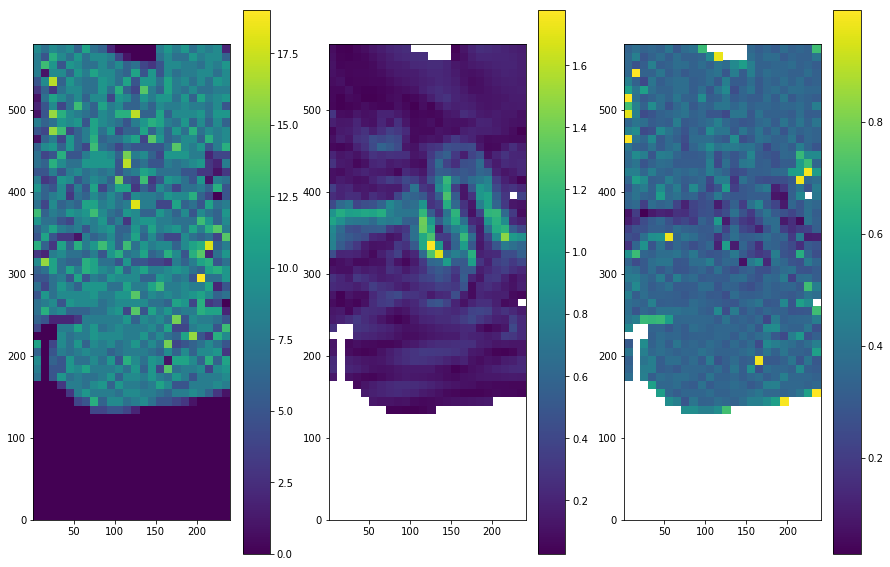

In [81]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,3,1)
cs = ax.pcolor(X,Y,Count.T)
ax.set_aspect('equal')
plt.colorbar(cs)
ax1 = fig.add_subplot(1,3,2)
cs1 = ax1.pcolor(X,Y,Mean.T)
ax1.set_aspect('equal')
plt.colorbar(cs1)
ax2 = fig.add_subplot(1,3,3)
cs2 = ax2.pcolor(X,Y,Err.T)
ax2.set_aspect('equal')
plt.colorbar(cs2)

In [ ]:
count, meansq = 

### residual velocity:

In [85]:
UU = np.repeat(U_mean.values,df_pd.time.unique().size)

In [99]:
df_pd = df_pd.sort_values('id').set_index('id')

### Mean currents model

In [82]:
gparams = {'f0': 1.0313e-4, 'beta': 1.6186e-11}
r = pp.CROCOrun(root_path+run, prefix='file_', open_nc=['surf'], 
                chunk_time={'his': 1, 'surf': 1}, grid_params=gparams)

In [75]:
ds = r['surf'].assign_coords(time=ds.time_counter)

In [76]:
dsi = ds.sel(time=slice(1500,1600))

In [84]:
dsi.u.shape

(14400, 1, 722, 257)

In [78]:
def u2rho(var_u):
    [Tp,Mp,L] = var_u.shape
    Lp = L+1
    Lm = L-1
    u_rho = np.zeros((Tp,Mp,Lp))
    u_rho[:,:,1:L]=0.5*(var_u[:,:,0:Lm]+var_u[:,:,1:L])
    u_rho[:,:,0]=u_rho[:,:,1]
    u_rho[:,:,Lp-1]=u_rho[:,:,L-1]
    return u_rho
def v2rho(var_v):
    [Tp,M,Lp] = var_v.shape
    Mp = M+1
    Mm = M-1
    v_rho = np.zeros((Tp,Mp,Lp))
    v_rho[:,1:M,:]=0.5*(var_v[:,0:Mm,:]+var_v[:,1:M,:])
    v_rho[:,0,:]=v_rho[:,1,:]
    v_rho[:,Mp-1,:]=v_rho[:,M-1,:]
    return v_rho

In [ ]:
v_rho = v2rho(dsi.v[:,0,:,:].values)

In [ ]:
u_rho = u2rho(dsi.u[:,0,:,:].values)

In [ ]:
U_rho = np.sqrt(u_rho**2+v_rho**2)

In [64]:
u_rho

array([[[-0.00111934, -0.00111934, -0.00111861, ..., -0.00115353,
         -0.00112403, -0.00112403],
        [-0.0020523 , -0.0020523 , -0.00204775, ..., -0.00208602,
         -0.00206088, -0.00206088],
        [-0.0030516 , -0.0030516 , -0.00304153, ..., -0.00308267,
         -0.00306402, -0.00306402],
        ...,
        [ 0.00232081,  0.00232081,  0.00214107, ...,  0.00267431,
          0.00249855,  0.00249855],
        [ 0.00232446,  0.00232446,  0.00214411, ...,  0.0026786 ,
          0.00250263,  0.00250263],
        [ 0.00072376,  0.00072376,  0.00060366, ...,  0.00095653,
          0.00084117,  0.00084117]],

       [[-0.00167006, -0.00167006, -0.00167052, ..., -0.00170822,
         -0.00167516, -0.00167516],
        [-0.00262603, -0.00262603, -0.00262221, ..., -0.00266308,
         -0.00263504, -0.00263504],
        [-0.00363864, -0.00363864, -0.00362932, ..., -0.00367262,
         -0.00365144, -0.00365144],
        ...,
        [ 0.00231158,  0.00231158,  0.00213145, ...,  

In [95]:
slice(0,4,2)

slice(0, 4, 2)

In [ ]:
umt = u_rho.mean(axis=0).mean(axis=1)#slice(0,2,2))
vmt = v_rho.mean(axis=0).mean(axis=0)

(1, 250)

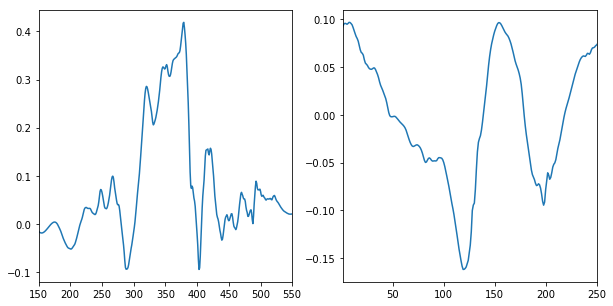

In [107]:
fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(umt)
plt.xlim(150,550)
plt.subplot(1,2,2)
plt.plot(vmt)
plt.xlim(1,250)

In [ ]:
umean_rho = u_rho.mean(axis=0)
vmean_rho = v_rho.mean(axis=0)
Umean_rho = U_rho.mean(axis=0)

In [ ]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,3,1)
cs = ax.pcolor(Umean_rho,vmax=2,vmin=0)
plt.colorbar(cs)
ax.set_aspect('equal')
ax1 = fig.add_subplot(1,3,2)
cs1 = ax1.pcolor(umean_rho,vmax=1.5,vmin=-1.)
ax1.set_aspect('equal')
plt.colorbar(cs1)
ax2 = fig.add_subplot(1,3,3)
cs2 = ax2.pcolor(vmean_rho,vmax=1.5,vmin=-1.5)
ax2.set_aspect('equal')
plt.colorbar(cs2)

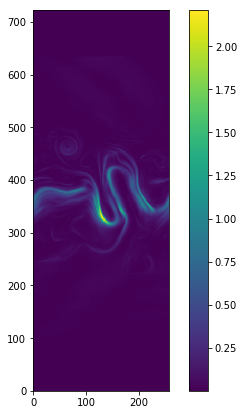

In [63]:
fig,ax = plt.subplots(figsize=(7,7))
cs = ax.pcolor(0.5*(Umean_rho**2))
plt.colorbar(cs)
ax.set_aspect('equal')

In [68]:
time = dsi.time_counter   

In [69]:
time

<xarray.DataArray 'time_counter' (time: 100)>
array([1510.420139, 1510.427083, 1510.434028, 1510.440972, 1510.447917,
       1510.454861, 1510.461806, 1510.46875 , 1510.475694, 1510.482639,
       1510.489583, 1510.496528, 1510.503472, 1510.510417, 1510.517361,
       1510.524306, 1510.53125 , 1510.538194, 1510.545139, 1510.552083,
       1510.559028, 1510.565972, 1510.572917, 1510.579861, 1510.586806,
       1510.59375 , 1510.600694, 1510.607639, 1510.614583, 1510.621528,
       1510.628472, 1510.635417, 1510.642361, 1510.649306, 1510.65625 ,
       1510.663194, 1510.670139, 1510.677083, 1510.684028, 1510.690972,
       1510.697917, 1510.704861, 1510.711806, 1510.71875 , 1510.725694,
       1510.732639, 1510.739583, 1510.746528, 1510.753472, 1510.760417,
       1510.767361, 1510.774306, 1510.78125 , 1510.788194, 1510.795139,
       1510.802083, 1510.809028, 1510.815972, 1510.822917, 1510.829861,
       1510.836806, 1510.84375 , 1510.850694, 1510.857639, 1510.864583,
       1510.871528

In [25]:
umean_surf = dsi.u[:,0,:,:].mean(axis=0)

In [26]:
vmean_surf = dsi.v[:,0,:,:].mean(axis=0)

In [ ]:
v_mean = ds.v[:,0,:,:].mean(axis=0)

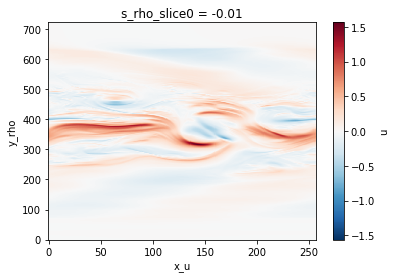

In [24]:
u_mean.plot()

In [27]:
dsi.

AttributeError: 'Dataset' object has no attribute 'stats'

In [ ]:
cluster.close()